# Saving Loess Detrended Data
Saving all data with loess detrend.

<b> PHD-1 </b>
* Switched read_and_merge_netcdfs from longrunmip_loaded function to open_ds - all opening files are now done within the one py file
* longrunmip loader removed. Better just to load files in one by one
* Moved from init to top level
* Removed all extra code (see nb 23 in init for old code).


In [2]:
import xarray as xr
from importlib import reload
import numpy as np
import pandas as pd
import os
from time import perf_counter
import matplotlib.pyplot as plt
import sys
sys.path.append('modules')
import constants
import xarray_class_accessors as xca
import open_ds
import utils
from classes import ExperimentTypes
from warnings import filterwarnings
filterwarnings('ignore')
from functools import partial
from time import perf_counter
from multiprocessing import Pool

In [3]:
# Notes: Surf contains a T cell extra variable and also return divide by 0 error.
variable = 'surf' # pr, tas, tos, 

ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable,'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/surf/regrid_retimestamped'

In [4]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [5]:
files_to_open_abrupt4x = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                                    ExperimentTypes.ABRUPT4X, 
                                                                    models_to_get)
utils.pprint_list(files_to_open_abrupt4x)

- model='ccsm3' - found_fname=None - No file found
- model='ipslcm5a' - found_fname=None - No file found
lenght = 5
 0. surf_ann_CESM104_abrupt4x_5900_g025.nc
 1. surf_ann_CNRMCM61_abrupt4x_1850_g025.nc


In [5]:
# files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR,
#                                                                     ExperimentTypes.CONTROL, 
#                                                                     models_to_get)
# utils.pprint_list(files_to_open_control)

# Functions

In [6]:
def get_lowess_metadata() -> dict[str, str]:
    now = pd.Timestamp.now().strftime(format = '%Y/%m/%d')
    history = {'history': f'Modified by Alex Borowiak on {now}','stats': 'loess detrended data'}
    return history

In [7]:
def open_and_data_and_apply_loess_filter(fname, ROOT_DIR, OUTPUT_DIR):
    print(f'{fname} -> {os.path.join(OUTPUT_DIR, fname)}\n')
    ds = xr.open_dataarray(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks)
    
    ds_loess = ds.sn.loess_grid()
    
    ds_loess.attrs = {**ds_loess.attrs, **get_lowess_metadata()}
    
    ds_loess.to_netcdf(os.path.join(OUTPUT_DIR, fname))
    print(f'{fname} completed') 

# Single Model Sample

In [8]:
fname = files_to_open_abrupt4x[0]
fname

'surf_ann_CCSM3_abrupt4x_2130_g025.nc'

In [9]:
REGRID_LAT = 72
REGRID_LON = 144

In [10]:
chunks = {'lat':72/4,'lon':144/4,'time':-1}
ds = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks)
ds

<xarray.Dataset>
Dimensions:  (lon: 144, lat: 72, time: 2120)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) object 0001-12-31 00:00:00 ... 2120-12-31 00:00:00
Data variables:
    surf     (time, lat, lon) float32 dask.array<chunksize=(2120, 18, 36), meta=np.ndarray>
    TAREA    (lat, lon) float32 dask.array<chunksize=(18, 36), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Fri Jul 08 00:21:34 2016: cdo remapbil,mygrid surf_CCSM3_ab...
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...

In [11]:
da = ds[variable]

In [12]:
%%time
# Time taken for pr_mon_CCSM3_abrupt4x_2120_g025: 1h 9min 44s
da_loess = da.sel(lat=slice(-20, -15), lon=slice(110, 115)).sn.apply_loess_filter()

CPU times: user 2.08 s, sys: 188 ms, total: 2.26 s
Wall time: 2.95 s


In [13]:
da_loess.attrs = {**da_loess.attrs, **get_lowess_metadata()}

In [14]:
sel_kwargs = dict(lat=-20, lon=115, method='nearest')

Text(0.5, 1.0, 'Lowess')

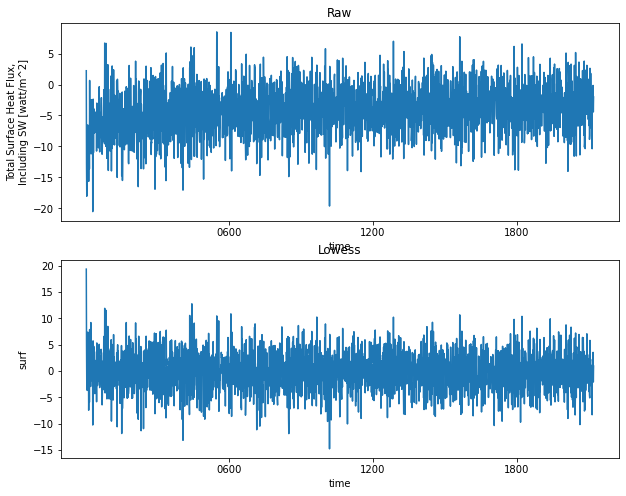

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))

da.sel(**sel_kwargs).plot(ax=ax1, label='raw')
da_loess.sel(**sel_kwargs).plot(ax=ax2, label='lowess')
ax1.set_title('Raw')
ax2.set_title('Lowess')

# All Files

In [17]:
chunks = {'lat':72/4,'lon':144/4,'time':-1}

In [18]:
OUTPUT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable, 'lowess')
utils.mkdir_no_error(OUTPUT_DIR)
OUTPUT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/surf/lowess'

In [19]:
len(files_to_open_abrupt4x)

5

In [20]:
MAX_LENGTH = 1400

In [21]:
ds

<xarray.Dataset>
Dimensions:  (time: 1850, lat: 72, lon: 144)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1850-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    surf     (time, lat, lon) float32 dask.array<chunksize=(1850, 18, 36), meta=np.ndarray>
Attributes: (12/57)
    CDI:                       Climate Data Interface version 1.9.5 (http://m...
    history:                   Fri May 10 17:09:21 2019: cdo remapbil,mygrid ...
    source:                    CNRM-CM6-1 (2017):  aerosol: prescribed monthl...
    institution:               CNRM (Centre National de Recherches Meteorolog...
    Conventions:               CF-1.7 CMIP-6.2
    creation_date:             2018-03-21T10:27:14Z
    ...                        ...
    nemo_gelato_commit:        49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:      6.3.1
    nco_openmp_thread_number:  1
    NCO:                       "4.5.5"
    tracking_id:               hdl:21.14100/dcafa2be-0400-4bce-bbb2-958e98565766
    CDO:                       Climate Data Operators version 1.9.5 (http://m...

In [22]:
failed_files = []
for i,fname in enumerate(files_to_open_abrupt4x):
    t1 = perf_counter()
    print(f'{i+1}: {fname} ', end='')
    try:
        ds = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks)#.to_array()
        
        # Sometimes there are extra variables.
        da = ds[variable]
        da = da.isel(time=slice(None, MAX_LENGTH))

        da_loess = da.sn.apply_loess_filter()

        da_loess.attrs = {**da_loess.attrs, **get_lowess_metadata()}

        print(f' -> {os.path.join(OUTPUT_DIR, fname)}', end ='')
        da_loess.to_netcdf(os.path.join(OUTPUT_DIR, fname))
        t2 = perf_counter()
        print(f' ({t2-t1})')
    except ZeroDivisionError as e:
        failed_files.append({fname: 'ZeroDivisionError'})
        print(e)

1: surf_ann_CNRMCM61_abrupt4x_1850_g025.nc  -> /g/data/w40/ab2313/PhD/longrunmip/surf/lowess/surf_ann_CNRMCM61_abrupt4x_1850_g025.nc (1677.0978457229212)
2: surf_ann_HadCM3L_abrupt4x_1000_g025.nc  -> /g/data/w40/ab2313/PhD/longrunmip/surf/lowess/surf_ann_HadCM3L_abrupt4x_1000_g025.nc (1755.2576387235895)
3: surf_ann_MPIESM11_abrupt4x_4520_g025.nc  -> /g/data/w40/ab2313/PhD/longrunmip/surf/lowess/surf_ann_MPIESM11_abrupt4x_4520_g025.nc (1607.13910781499)
4: surf_ann_MPIESM12_abrupt4x_1000_g025.nc  -> /g/data/w40/ab2313/PhD/longrunmip/surf/lowess/surf_ann_MPIESM12_abrupt4x_1000_g025.nc (1191.727436721325)


# With MulitProcessing

In [109]:
# from functools import partial
# from multiprocessing import Pool

# import utils
# logger = utils.get_notebook_logger()

# OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'test_csm')

# try:
#     os.mkdir(OUTPUT_DIR)
# except FileExistsError as e:
#     pass

# utils.change_logging_level('DEBUG')

# def open_and_data_and_apply_loess_filter(fname, ROOT_DIR, OUPTUT_DIR):
#     t1 = perf_counter()
#     logger.info(f'{i+1}: {fname} ', end='')
#     try:
#         da = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True, chunks=chunks).to_array()
#         da = da.isel(time=slice(None, MAX_LENGTH))

#         da_loess = da.sn.loess_grid()

#         da_loess.attrs = {**ds_loess.attrs, **get_lowess_metadata()}

#         logger.debug(f' -> {os.path.join(OUTPUT_DIR, fname)}', end ='')
#         da_loess.to_netcdf(os.path.join(OUTPUT_DIR, fname))
#         t2 = perf_counter()
#         logger.debug(f' ({t2-t1})')
#     except ZeroDivisionError as e:
#         failed_files.append({fname: 'ZeroDivisionError'})
#         logger.error(e)

# open_and_data_and_apply_loess_filter_partial = partial(open_and_data_and_apply_loess_filter,
#                                               ROOT_DIR=ROOT_DIR, OUTPUT_DIR=OUTPUT_DIR)

# %%time
# with Pool() as pool:
#     pool.map(open_and_data_and_apply_loess_filter_partial, 
#              chain(files_to_open_control, files_to_open_abrupt4x))